# UP42 Satellite Image Ordering 101

Building on a [previous](https://up42.com/blog/tech/webhooks-exploring-local-developments-openresty) article, this notebook provides a recipe for:

 1. Searching for data.
 2. Ordering the selected data.
 3. Get notified via a webhook when the order(s) get(s) delivered.

**N.B.**: Make sure you are using a version  **$\ge$ 0.22.0**. This is the version where support for webhooks was introduced.

## Installing the UP42 Python SDK

The module is called `up42`. Python **>= 3.8** is **required**.

 1. Create a virtual environment.
```bash
 mkvirtualenv --python=$(which python3) up42-py
```
 2. Activate the environment.
```bash
 workon up42-py
```
 3. Install the module.
 ```bash
 pip install up42-py
 ```
 4. Install Jupyter Lab.
```bash
 pip install jupyterlab
 ```
 5. Done.
 
Now we can just import it.

In [1]:
import up42

## Authenticate with project ID and project key
The project API key and the project ID are read from a JSON file. This file has the following structure:
```
{
  "project_id": "<your-project-ID-here>",
  "project_api_key": "<your-api-key-here>"
}
```
To find out how to obtain the project API key and project ID the please refer to the [documentation].(https://docs.up42.com/processing-platform/projects#developers)

Reading the credentials from the JSON file `~/.up42/proj_default.json`.

In [2]:
from pathlib import Path

project_config_file = Path.home() /  ".up42" / "proj_default.json"
up42.authenticate(cfg_file = project_config_file)

2022-09-01 19:43:22,273 - Got credentials from config file.
2022-09-01 19:43:23,880 - Authentication with UP42 successful!


## Create a webhook for handling order statuses

First we look at the available notifiable events.

We just invoke the [`get_webhook_events`](https://sdk.up42.com/reference/webhooks-reference/#up42.webhooks.Webhooks.get_webhook_events) method.

In [3]:
up42.get_webhook_events()

[{'name': 'job.status',
  'title': 'Job Status Updates',
  'category': 'job',
  'description': 'Sent when job/task status is updated',
  'documentation': 'https://docs.up42.com/developers/'},
 {'name': 'order.status',
  'title': 'Order Status Updates',
  'category': 'order',
  'description': 'Sent when order status is updated',
  'documentation': 'https://docs.up42.com/developers/'}]

There are two types of events: `job.status` for notifying about jobs and `order.status` for notifiyng about orders. Since this notebooks deals with orders *solely* is the `order.status` event that we are interested in.  

## Create the webhook

We want now to manipulate a specific webhook. For that we build a list of `(<name>, <id>)` tuples for each webhook.
Let us first define the secret. 

**N.B.** This is just an example. Choosw one secret that is hard to guess and up to **500** characters long.

In [4]:
wh_order101_secret = "the mighty fox jumped over the normal lazy dog"

In [5]:
wh_order101 = up42.create_webhook(name="ordering 101 webhook",
                                  url="https://eophenon9705lt2.m.pipedream.net",
                                  events=["order.status"],
                                  secret=wh_order101_secret)

2022-09-01 19:43:24,914 - Created webhook Webhook(name: ordering 101 webhook, webhook_id: 8863d1ea-78e8-4c0c-a68e-8684329813b6, active: False


The webhook is not active **yet**. First we want to test it.

Let us now see what methods we have available. We are going to use a small module with helper functions.

We want to list all the non-magic methods that this class posesses. Somewhat similar to Julia's [methodswith](https://docs.julialang.org/en/v1/stdlib/InteractiveUtils/#InteractiveUtils.methodswith).

In [6]:
import pynb_helpers.misc as misc

misc.methods(type(wh_order101))

[('trigger_test_events', <Signature (self) -> dict>),
 ('update',
  <Signature (self, name: Optional[str] = None, url: Optional[str] = None, events: Optional[List[str]] = None, active: Optional[bool] = None, secret: Optional[str] = None) -> 'Webhook'>),
 ('delete', <Signature (self) -> None>)]

## Testing the webhook

Before we proceed we want to [test](https://docs.up42.com/developers/api#operation/runWebhookTests) the webhook. We already know the name and signature of the function. Is named `trigger_test_events` and takes no arguments.

In [7]:
wh_order101.trigger_test_events()

{'startedAt': '2022-09-01T17:43:25.904773Z',
 'testsRun': 1,
 'testsSucceeded': 1,
 'testsFailed': 0,
 'tests': [{'startedAt': '2022-09-01T17:43:26.31134Z',
   'eventName': 'order.status',
   'success': True,
   'message': 'Test request was successful!',
   'request': {'headers': {'caseInsensitiveName': True, 'empty': False},
    'body': {'event': 'order.status',
     'liveMode': False,
     'messageId': '6d2a99e1-bf0e-4027-82f1-52c30f15b4aa',
     'timestamp': '2022-09-01T17:43:25.904923Z',
     'body': {'orderId': '00000000-0000-0000-0000-000000000001',
      'orderType': 'TASKING',
      'dataHostName': 'test-up42-host-name',
      'status': 'FULFILLED',
      'statusIsFinal': True}}},
   'response': 'HttpResponse[https://eophenon9705lt2.m.pipedream.net/, 200 OK]'}]}

Now that we tested the webhook we proceed to the ordering.

## Searching for data

We now look for existing data in the region we are interested in. The AOI is defined via a GeoJSON file in the `examples` directory. Let us use [ipyleaflet](https://ipyleaflet.readthedocs.io/) to visualize it.

In [8]:
from ipyleaflet import Map, GeoJSON

In [9]:
# Path to the AOI GeoJSON.
path2aoi = "../examples/portinho_arrabida.geojson"

In [10]:
import json
with open(path2aoi, "r") as f:
    aoi_map = json.load(f)

### Drawing the AOI in a map

In [11]:
map = Map(center=(38.47064394226866, -8.984506813116552), zoom=14)

# Add the AOI to the map. First style it and then add it.
aoi_layer = GeoJSON(
    data=aoi_map,
    style={
        "opacity": 1, "dashArray": "9", "fillOpacity": 0.5, "weight": 1
    },
    hover_style={
        "color": "yellow", 'dashArray': "0", "fillOpacity": 0.5
    },
)
map.add_layer(aoi_layer)
map

Map(center=[38.47064394226866, -8.984506813116552], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Searching for data in the catalog

We need to instantiate a catalog object and perform a [search](https://sdk.up42.com/search_order/#search-image-in-the-catalog).

In [12]:
catalog = up42.initialize_catalog()

Let us list the name of the available archive data collections from Airbus hosted by OneAtlas.

In [13]:
[ (c["name"], c["description"]) for c in catalog.get_collections() 
     if c["type"].lower() == "archive" and c["hostName"] == "oneatlas" ]

[('pneo',
  'Very high-resolution 30cm Pléiades Neo images acquired bidaily on a global basis. The datasets are available starting from November 2021.'),
 ('phr',
  'Very high-resolution 50cm Pléiades images acquired daily on a global basis. The datasets are available starting from 2012.'),
 ('spot',
  'High-resolution 1.5m SPOT images acquired daily on a global basis. The datasets are available starting from 2012.')]

We are interested in images from the **Pléiades** optical satellite constellation: 50 cm resolution. I.e., the archive collection named `phr`.

We are looking for Pléiades archive images acquired in 2022 and with a cloud coverage of at most 10%.

In [14]:
search_params = catalog.construct_parameters(geometry=aoi_map,
                                             start_date="2022-01-01",
                                             end_date="2022-12-31",
                                             collections=["phr"],
                                             max_cloudcover=10,
                                             sortby="acquisitionDate",
                                             ascending=False,
                                             limit=10)

In [15]:
search_results = catalog.search(search_parameters=search_params)

2022-09-01 19:43:26,785 - Searching catalog with search_parameters: {'datetime': '2022-01-01T00:00:00Z/2022-12-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-8.970508575439453, 38.48382914339068), (-8.98106575012207, 38.48141037533113), (-8.989777565002441, 38.47637101450613), (-8.992223739624023, 38.47015531764655), (-8.991966247558594, 38.46561920067743), (-8.990163803100586, 38.465518394837304), (-8.990421295166016, 38.46709767014416), (-8.986902236938477, 38.46978571879323), (-8.982696533203125, 38.47381760389001), (-8.984713554382324, 38.47600144751436), (-8.981409072875977, 38.47905871745382), (-8.97707462310791, 38.48026815108751), (-8.971881866455078, 38.48016736572641), (-8.96934986114502, 38.480604101273386), (-8.969564437866211, 38.481746320193345), (-8.968620300292969, 38.48208226348981), (-8.969006538391113, 38.48288852101284), (-8.970508575439453, 38.48382914339068)),)}, 'limit': 10, 'collections': ['phr'], 'query': {'cloudCoverage': {'lte': 10}, 'up4

In [16]:
search_results

,geometry,id,constellation,collection,providerName,up42:usageType,providerProperties,sceneId,producer,acquisitionDate,start_datetime,end_datetime,cloudCoverage,resolution,deliveryTime
0,"POLYGON ((-9.08728 39.19341, -9.08412 38.36209...",2a2b6c0d-ef0a-4aac-9c0d-e55957e5fd1a,phr,phr,oneatlas,[DATA],"{'commercialReference': 'SO22013070', 'qualifi...",2a2b6c0d-ef0a-4aac-9c0d-e55957e5fd1a,airbus,2022-03-18T11:24:06.055Z,None,None,6.7,0.5,MINUTES


We found exactly *one* (1) image. Let us obtain the quicklook for it (low resolution bitmap image preview).

2022-09-01 19:43:30,232 - Getting quicklooks from provider oneatlas for image_ids: ['2a2b6c0d-ef0a-4aac-9c0d-e55957e5fd1a']
2022-09-01 19:43:30,234 - Download directory: /Users/appa/up42/data-recipes/data-ordering101/notebooks/project_5ea6a20d-4fa9-42a1-8e29-f2d9b27b0097/catalog
100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


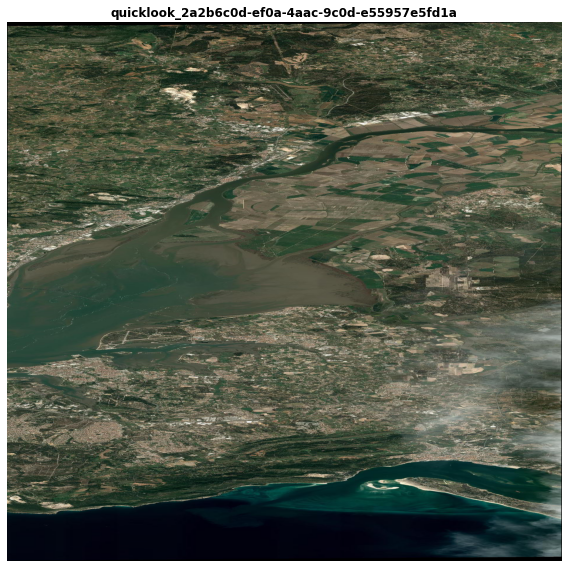

In [17]:
catalog.download_quicklooks(search_results.id.to_list(), sensor = "pleiades")
catalog.plot_quicklooks()

The quicklooks is always for the full scene.

## Placing the order

Now that we have chosen the image we want to order it. And we want to be notified when the order gets fulfilled. So before we place the order we need to activate the webhook we created above.

### Activating the webhook

Let us inspect the webhook settings/parameters.

In [18]:
wh_order101.__dict__

{'auth': UP42ProjectAuth(project_id=5ea6a20d-4fa9-42a1-8e29-f2d9b27b0097, env=com),
 'workspace_id': 'd39fe05a-400c-44f6-b770-86990f64b004',
 'webhook_id': '8863d1ea-78e8-4c0c-a68e-8684329813b6',
 '_info': {'url': 'https://eophenon9705lt2.m.pipedream.net',
  'name': 'ordering 101 webhook',
  'active': False,
  'events': ['order.status'],
  'id': '8863d1ea-78e8-4c0c-a68e-8684329813b6',
  'secret': 'the mighty fox jumped over the normal lazy dog',
  'createdAt': '2022-09-01T17:43:24.989774Z',
  'updatedAt': '2022-09-01T17:43:24.989774Z'}}

In [19]:
wh_order101.__dict__["_info"]

{'url': 'https://eophenon9705lt2.m.pipedream.net',
 'name': 'ordering 101 webhook',
 'active': False,
 'events': ['order.status'],
 'id': '8863d1ea-78e8-4c0c-a68e-8684329813b6',
 'secret': 'the mighty fox jumped over the normal lazy dog',
 'createdAt': '2022-09-01T17:43:24.989774Z',
 'updatedAt': '2022-09-01T17:43:24.989774Z'}

We need to [update](https://sdk.up42.com/reference/webhooks-reference/#up42.webhooks.Webhook.update) this webhook.

In [20]:
wh_order101.update(name="My webhook setup with ngrok", 
                   url=wh_order101.__dict__["_info"]["url"],
                   events=wh_order101.__dict__["_info"]["events"],
                   active=True, 
                   secret= wh_order101.__dict__["_info"]["secret"])

2022-09-01 19:43:35,918 - Updated webhook Webhook(name: My webhook setup with ngrok, webhook_id: 8863d1ea-78e8-4c0c-a68e-8684329813b6, active: True


Webhook(name: My webhook setup with ngrok, webhook_id: 8863d1ea-78e8-4c0c-a68e-8684329813b6, active: True

Let us check the webhook settings now.

In [21]:
wh_order101.__dict__["_info"]

{'url': 'https://eophenon9705lt2.m.pipedream.net',
 'name': 'My webhook setup with ngrok',
 'active': True,
 'events': ['order.status'],
 'id': '8863d1ea-78e8-4c0c-a68e-8684329813b6',
 'secret': 'the mighty fox jumped over the normal lazy dog',
 'createdAt': '2022-09-01T17:43:24.989774Z',
 'updatedAt': '2022-09-01T17:43:35.955025Z'}

We see that the webhook is now **active**.

### Placing the order

Now to [order](https://sdk.up42.com/search_order/#order-the-image) the image we use the only data frame returned by the search. 

#### Estimating the order

We estimate the cost of the order.

In [22]:
catalog.estimate_order(scene=search_results.loc[0], geometry = aoi_map)

2022-09-01 19:43:38,147 - Order with order parameters {'dataProviderName': 'oneatlas', 'orderParams': {'id': '2a2b6c0d-ef0a-4aac-9c0d-e55957e5fd1a', 'aoi': {'type': 'Polygon', 'coordinates': (((-8.970508575439453, 38.48382914339068), (-8.98106575012207, 38.48141037533113), (-8.989777565002441, 38.47637101450613), (-8.992223739624023, 38.47015531764655), (-8.991966247558594, 38.46561920067743), (-8.990163803100586, 38.465518394837304), (-8.990421295166016, 38.46709767014416), (-8.986902236938477, 38.46978571879323), (-8.982696533203125, 38.47381760389001), (-8.984713554382324, 38.47600144751436), (-8.981409072875977, 38.47905871745382), (-8.97707462310791, 38.48026815108751), (-8.971881866455078, 38.48016736572641), (-8.96934986114502, 38.480604101273386), (-8.969564437866211, 38.481746320193345), (-8.968620300292969, 38.48208226348981), (-8.969006538391113, 38.48288852101284), (-8.970508575439453, 38.48382914339068)),)}}} is estimated to cost 1010 UP42 credits.


1010

The cost is going to be **1010** credits, i.e., **10.1** EUR.

#### Ordering

We order an analytic product for this image.

In [23]:
catalog.place_order(scene=search_results.loc[0], geometry=aoi_map)

2022-09-01 19:43:46,507 - Order is PLACED
2022-09-01 19:43:46,508 - Order d28a249c-489b-4409-b939-dceb57d5b919 is now PLACED.


Order(order_id: d28a249c-489b-4409-b939-dceb57d5b919, assets: [], dataProvider: None, status: PLACED, createdAt: 2022-09-01T17:43:43.676818Z, updatedAt: 2022-09-01T17:43:45.767173Z)

We see that the order was placed. Now let us wait for the webhook notification relative to it.

## Checking for order completion with webhooks & nginx

We need to load the [JSON lines](https://jsonlines.org/) (JSONL) file into the notebook and handle it as a data frame. First we need to import the helper functions to handle JSONL files.

In [24]:
from pynb_helpers import jsonl_io as jslio

### Checking the webhook nginx log file

The (JSONL) log file where the notifications from the webhook we created above are. Let us load it.

In [25]:
jsonl_logs_file = "../log/up42_order_log.jsonl"

In [26]:
log_data = jslio.load_jsonl(jsonl_logs_file)

Loaded 1 records from ../log/up42_order_log.jsonl.
Loaded 2 records from ../log/up42_order_log.jsonl.
Loaded 3 records from ../log/up42_order_log.jsonl.
Loaded 4 records from ../log/up42_order_log.jsonl.
Loaded 5 records from ../log/up42_order_log.jsonl.
Loaded 6 records from ../log/up42_order_log.jsonl.
Loaded 7 records from ../log/up42_order_log.jsonl.
Loaded 8 records from ../log/up42_order_log.jsonl.


Let us now read it into a data frame.

In [27]:
import pandas as pd

In [28]:
db_data = []
db_cols = ["date", "order_id", "status"]
for d in log_data:
    db_data.append([])
    for col in db_cols:
        db_data[-1].append(d[db_cols.index(col)])
        
df = pd.DataFrame(db_data, columns=db_cols)

In [29]:
df

,date,order_id,status
0,"Monday, 08-Aug-2022 17:09:15 UTC",044abd68-9b17-4424-a0a7-80f4650b93c2,FULLFILED
1,"Monday, 08-Aug-2022 17:10:12 UTC",ea0d0e66-3f2c-4bb9-9b44-86bee49b9f4f,FULLFILED
2,"Monday, 08-Aug-2022 17:15:24 UTC",09951ac9-8170-4388-a947-e25733ff03ba,FULFILLED
3,"Monday, 08-Aug-2022 17:15:34 UTC",68022767-1e13-492f-83e9-4780636fe10f,FULFILLED
4,"Wednesday, 10-Aug-2022 16:42:18 UTC",00000000-0000-0000-0000-000000000001,FULFILLED
5,"Wednesday, 10-Aug-2022 16:43:43 UTC",00000000-0000-0000-0000-000000000001,FULFILLED
6,"Wednesday, 10-Aug-2022 16:44:23 UTC",00000000-0000-0000-0000-000000000001,FULFILLED
7,"Thursday, 11-Aug-2022 05:01:36 UTC",92ceac2c-a89f-4e66-9a8d-b20f336d8799,FULFILLED


The order we are interested is in row 7. 

In [30]:
df.loc[7]

date          Thursday, 11-Aug-2022 05:01:36 UTC
order_id    92ceac2c-a89f-4e66-9a8d-b20f336d8799
status                                 FULFILLED
Name: 7, dtype: object

## Getting the asset associated with the order

Using the [Order](https://sdk.up42.com/reference/order-reference/) _module_ of the SDK.

In [31]:
order101 = up42.initialize_order(df.loc[7].order_id)

2022-09-01 19:43:46,878 - Initialized Order(order_id: 92ceac2c-a89f-4e66-9a8d-b20f336d8799, assets: ['fa438b5e-0903-4787-8958-45a376dd9b04'], dataProvider: None, status: FULFILLED, createdAt: 2022-08-11T04:57:11.381280Z, updatedAt: 2022-08-11T05:01:28.939351Z)


In [32]:
assets101 = order101.get_assets()

2022-09-01 19:43:47,105 - Order is FULFILLED


In [33]:
len(assets101)

1

There is only one asset, as expected, since there was only a single item returned by the search.

In [34]:
assets101[0].__dict__

{'auth': UP42ProjectAuth(project_id=5ea6a20d-4fa9-42a1-8e29-f2d9b27b0097, env=com),
 'workspace_id': 'd39fe05a-400c-44f6-b770-86990f64b004',
 'asset_id': 'fa438b5e-0903-4787-8958-45a376dd9b04',
 'results': None,
 '_info': {'id': 'fa438b5e-0903-4787-8958-45a376dd9b04',
  'workspaceId': 'd39fe05a-400c-44f6-b770-86990f64b004',
  'createdAt': '2022-08-11T05:01:27.213213Z',
  'type': 'ARCHIVED',
  'source': 'ORDER',
  'name': 'oneatlas_92ceac2c-a89f-4e66-9a8d-b20f336d8799.zip',
  'size': 8931983,
  'metadata': {'geometry': {'type': 'Polygon',
    'coordinates': [[[-8.970508575439453, 38.48382914339068],
      [-8.98106575012207, 38.48141037533113],
      [-8.989777565002441, 38.47637101450613],
      [-8.992223739624023, 38.47015531764655],
      [-8.991966247558594, 38.46561920067743],
      [-8.990163803100586, 38.465518394837304],
      [-8.990421295166016, 38.46709767014416],
      [-8.986902236938477, 38.46978571879323],
      [-8.982696533203125, 38.47381760389001],
      [-8.98471355

The asset ID is:

In [35]:
assets101[0].asset_id

'fa438b5e-0903-4787-8958-45a376dd9b04'

Next step is to download this asset from the UP42 [Storage](https://sdk.up42.com/storage/#access-download-assets).

## Download the asset

In [36]:
asset101_storage = up42.initialize_asset(asset_id = assets101[0].asset_id)

2022-09-01 19:43:47,761 - Initialized Asset(name: oneatlas_92ceac2c-a89f-4e66-9a8d-b20f336d8799.zip, asset_id: fa438b5e-0903-4787-8958-45a376dd9b04, type: ARCHIVED, source: ORDER, createdAt: 2022-08-11T05:01:27.213213Z, size: 8931983)


In [37]:
asset101_storage.download(unpacking=False, output_directory=Path("..") / "examples")

2022-09-01 19:43:47,769 - Downloading asset fa438b5e-0903-4787-8958-45a376dd9b04
2022-09-01 19:43:47,771 - Download directory: ../examples
8723it [00:05, 1569.20it/s]
2022-09-01 19:43:53,879 - Download successful of original archive file to output_directory '../examples': output..zip. To automatically unpack the archive use `unpacking=True`


['../examples/output..zip']

Now that we have the image our next steps would be visualizing and/or processing it. The ordering process is now **concluded**.